In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from plasma_box import Plasma

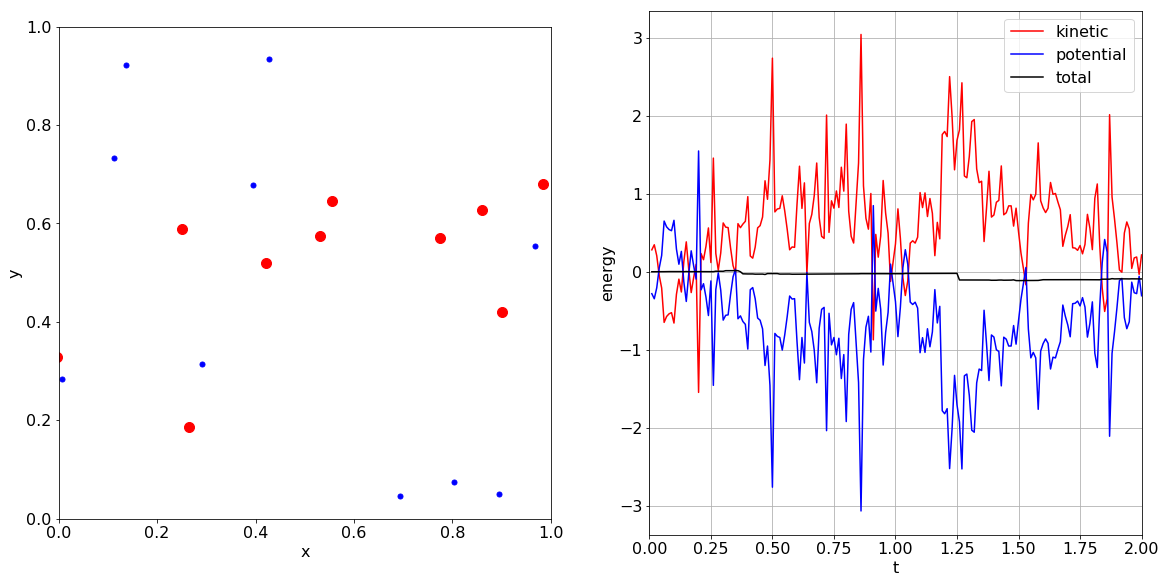

In [3]:
npart=10
plasma_temperature=5.
dt=1.e-2
tfin=2.

plas=Plasma(npart,temperature=plasma_temperature,electron_mass_ratio=1./5.,rtol=1.e-5)

plt.rcParams.update({'font.size': 16})
fig,(axp,axr) = plt.subplots(1,2,figsize=(16,8))
fig.subplots_adjust(left=0.05, bottom=0.08, right=0.99, top=0.99, wspace=None, hspace=None)
# plasma box
axp.set_xlim(0, 1)
axp.set_ylim(0, 1)
axp.set_aspect('equal', adjustable='box')
axp.set_xlabel('x')
axp.set_ylabel('y')

# energy recording
axr.set_xlim(0,tfin)
axr.set_autoscale_on
axr.set_xlabel('t')
axr.set_ylabel('energy')
axr.grid()

elec, = axp.plot([],[],'.b',markersize=10)
ions, = axp.plot([],[],'.r',markersize=20)
kin,  = axr.plot([],[],'-r',label='kinetic')
pot,  = axr.plot([],[],'-b',label='potential')
erg,  = axr.plot([],[],'-k',label='total')

axr.legend()

def init():
    elec.set_data([],[])
    ions.set_data([],[])
    kin.set_data([],[])
    pot.set_data([],[])
    erg.set_data([],[])
    
    return elec,ions,kin,pot,erg

def animate(i):
    global dt, axp, axr, fig, plas
    
    #subsampling
    plas.push(dt)
        
    x,y=plas.get_electrons()
    elec.set_data(x,y)
    x,y=plas.get_ions()
    ions.set_data(x,y)
  
    erg.set_xdata(np.append(erg.get_xdata(),plas.t))
    erg.set_ydata(np.append(erg.get_ydata(),plas.toterg()-plas.T0))
    
    kin.set_xdata(np.append(kin.get_xdata(),plas.t))
    kin.set_ydata(np.append(kin.get_ydata(),plas.kinerg()-plas.K0))
    
    pot.set_xdata(np.append(pot.get_xdata(),plas.t))
    pot.set_ydata(np.append(pot.get_ydata(),plas.poterg()-plas.V0))
             
    axr.relim()
    axr.autoscale_view()

    return elec,ions,kin,pot,erg

ani = anim.FuncAnimation(fig,animate,frames=int(tfin/dt),interval=10,blit=True,init_func=init)

ani.save('plasma_box.mp4',fps=24,extra_args=['-vcodec','libx264'])
    
plt.show()